In [1]:
using Distributed
using SharedArrays
addprocs(2);

In [2]:
@everywhere include("inverse_prob.jl")
@everywhere using PyPlot
@everywhere using DSP;

从实验的结果来看，reg = 1e-5, reg_m = 1e0, iterMax = 1000
还可以，就是算得慢，笔记本吃不消。

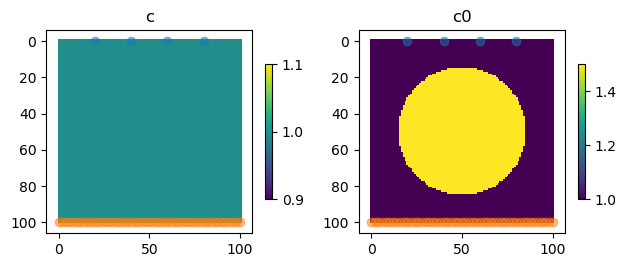

In [3]:
@eval @everywhere begin
    Nx = 101;
    Ny = 101;
    h = 0.01;
    x = range(0,step=h,length=Nx)
    y = range(0,step=h,length=Ny)

    Fs = 300;
    dt = 1/Fs
    Nt = 600;
    t = range(0, length=Nt, step=dt)

    source = source_ricker(8, 0.2, t)
    f = digitalfilter(Lowpass(2, fs = Fs), FIRWindow(hamming(61)))
    source = conv(source,f)
    source = source[31:end-30]
    source = source./ maximum(source)
    
    source_position = zeros(4,2)
    for i = 1:4
        source_position[i,:] = [1 20*(i-1)+21]
#         source_position[i,:] = [1 51]
    end
    source = repeat(source, 1, 4)

    receiver_position = zeros(51,2)
    for i = 1:51
        receiver_position[i,:] = [101, (i-1)*2+1]
    end

    c0 = ones(Nx, Ny)
    rho0 = ones(Nx, Ny)
    for i = 1:Nx
        for j = 1:Ny
            if sqrt((x[i]-0.5).^2 + (y[j]-0.5).^2) < 0.35
                c0[i,j] = 1.5
            end
        end
    end

    c = ones(Nx, Ny)
    # c[21:end,:] = imfilter(c0[21:end,:], Kernel.gaussian(5));
    rho = ones(Nx, Ny);
end
figure
subplot(121)
imshow(c); colorbar(shrink=0.3); title("c"); 
scatter(source_position[:,2].-1, source_position[:,1].-1, alpha=0.5)
scatter(receiver_position[:,2].-1, receiver_position[:,1].-1, alpha=0.5)
subplot(122)
imshow(c0); colorbar(shrink=0.3); title("c0"); 
scatter(source_position[:,2].-1, source_position[:,1].-1, alpha=0.5)
scatter(receiver_position[:,2].-1, receiver_position[:,1].-1, alpha=0.5)
tight_layout()

In [4]:
@time data, u = multi_solver_parallel(c, rho, Nx, Ny, Nt, h, dt, source, source_position, receiver_position; pml_len=10, pml_coef=100, save_ratio=4);

@time data0, u0 = multi_solver_parallel(c0, rho0, Nx, Ny, Nt, h, dt, source, source_position, receiver_position; pml_len=10, pml_coef=100, save_ratio=4);

 15.862597 seconds (7.64 M allocations: 383.018 MiB, 0.96% gc time)
  9.603822 seconds (1.71 k allocations: 102.875 KiB)


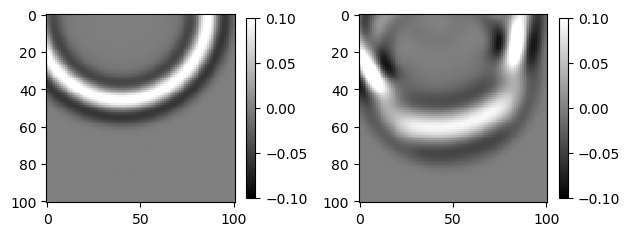

In [5]:
figure;
subplot(121); imshow(u[:,:,50,2],cmap=ColorMap("gray")); colorbar(shrink=0.4); clim(-0.1,0.1)
subplot(122); imshow(u0[:,:,50,2],cmap=ColorMap("gray")); colorbar(shrink=0.4); clim(-0.1,0.1)
tight_layout()

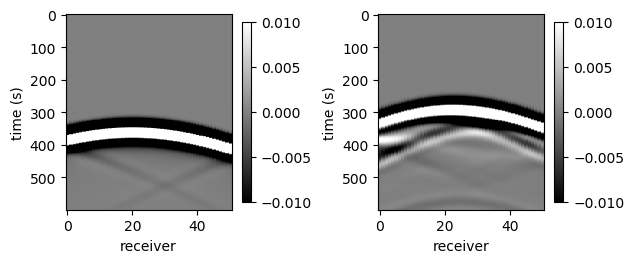

In [6]:
figure;
r_axis = 0:21
subplot(121); imshow(data[:,:,2],cmap=ColorMap("gray"), aspect=0.1); colorbar(shrink=0.4); clim([-0.01,0.01])
xlabel("receiver"); ylabel("time (s)")
subplot(122); imshow(data0[:,:,2],cmap=ColorMap("gray"), aspect=0.1); colorbar(shrink=0.4); clim([-0.01,0.01])
xlabel("receiver"); ylabel("time (s)")
tight_layout()

In [7]:
M = cost_matrix_1d(t,t; p=2)
reg = 1e-5
reg_m = 1e0
reg_p = 0.5
iterMax = 3000;

save_ratio = 4;

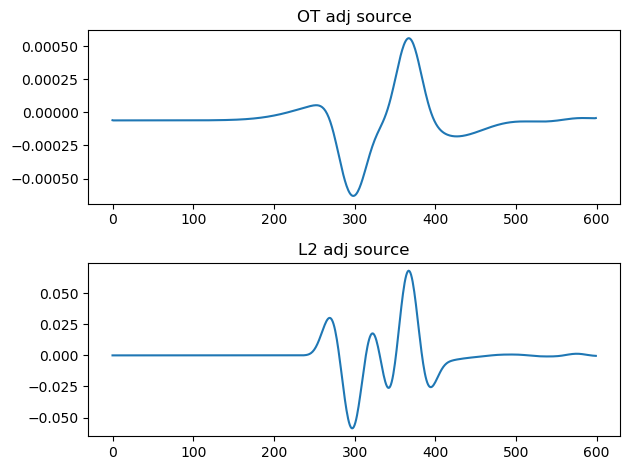

In [8]:
f = data[:,30,2] .+ reg_p
g = data0[:,30,2] .+ reg_p

TT,gg,dd = unbalanced_sinkhorn_1d(f, g, M, reg, reg_m; iterMax=iterMax);
subplot(211); plot(gg); title("OT adj source")
subplot(212); plot(f-g); title("L2 adj source")
tight_layout()

In [9]:
obj_func_ot(x) = obj_fn_sinkhorn_parallel(data0, x, rho, Nx, Ny, Nt, h, dt, source, source_position, receiver_position; cutoff=0, save_ratio=save_ratio, pml_len=10, pml_coef=100, reg=reg, reg_m=reg_m, reg_p=reg_p, iterMax=iterMax, verbose=false)

obj_func_l2(x) = obj_fn_parallel(data0, x, rho, Nx, Ny, Nt, h, dt, source, source_position, receiver_position; save_ratio=save_ratio, pml_len=10, pml_coef=100)


obj_func_l2 (generic function with 1 method)

In [10]:
x0 = c[:]
alpha = 1
iterNum = 3
min_value = 1
max_value = 1.2

# xk_ot, fn_value_ot = gradient_descent(obj_func_ot, x0, alpha, iterNum, min_value, max_value; rho=0.5, c=1e-5, maxSearchTime=3, threshold=1e-10);

In [11]:
imshow(reshape(xk,Nx,Ny)); colorbar()

UndefVarError: UndefVarError: xk not defined

In [12]:
xk_l2, fn_value_l2 = gradient_descent(obj_func_l2, x0, alpha, iterNum, min_value, max_value; rho=0.5, c=1e-5, maxSearchTime=3, threshold=1e-10);

Main iteration: 1
Start line search. fk: 4.89300e-02
    alpha: 1.00000e+00    fk1: 4.84410e-02    fk-c*alpha*gradk^2: 4.89200e-02
Line search succeed. Search time: 0.
----------------------------------------------------------------
Main iteration: 2
Start line search. fk: 4.84410e-02
    alpha: 1.00000e+00    fk1: 4.89085e-02    fk-c*alpha*gradk^2: 4.84310e-02
    alpha: 5.00000e-01    fk1: 4.85210e-02    fk-c*alpha*gradk^2: 4.84360e-02
    alpha: 2.50000e-01    fk1: 4.84451e-02    fk-c*alpha*gradk^2: 4.84385e-02
    alpha: 1.25000e-01    fk1: 4.84344e-02    fk-c*alpha*gradk^2: 4.84398e-02
Line search succeed. Search time: 3.
----------------------------------------------------------------
Main iteration: 3
Start line search. fk: 4.84344e-02
    alpha: 1.00000e+00    fk1: 4.90403e-02    fk-c*alpha*gradk^2: 4.84244e-02
    alpha: 5.00000e-01    fk1: 4.85786e-02    fk-c*alpha*gradk^2: 4.84294e-02
    alpha: 2.50000e-01    fk1: 4.84692e-02    fk-c*alpha*gradk^2: 4.84319e-02
    alpha: 1.

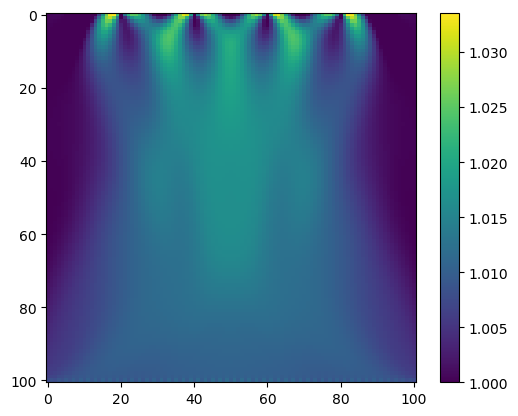

PyObject <matplotlib.colorbar.Colorbar object at 0x14e7d7f50>

In [13]:
imshow(reshape(xk_l2,Nx,Ny)); colorbar()